In [ ]:
!git clone https://github.com/dialogue-evaluation/RuREBus.git

In [2]:
import os
os.mkdir('/kaggle/working/data')
os.mkdir('/kaggle/working/data/train/')
os.mkdir('/kaggle/working/data/test/')

In [3]:
!unzip -q -j '/kaggle/working/RuREBus/train_data/train_part_1.zip' -d './data/train'
!unzip -q -j '/kaggle/working/RuREBus/train_data/train_part_2.zip' -d './data/train'
!unzip -q -j '/kaggle/working/RuREBus/train_data/train_part_3.zip' -d './data/train'
!unzip -q -j './RuREBus/test_data/test_ner_only.zip' -d './data/test'

In [1]:
import codecs
import bisect
import os
import torch
from torch import nn
from torch.autograd import Variable
import torch.utils.data as Data
import numpy as np
import sys
from tqdm import tqdm
import glob
import torch.autograd as autograd
import torch.optim as optim

torch.manual_seed(1)

In [2]:
class BratDoc:
    def __init__(self, data):
        self.txt_data = data # Str
        self.relations = [] # List[Tuple[str, int, int]]
        self.ners = [] # List[Tuple[str, int, int]]

        self.rel_id_2_idx = dict()
        self.ner_id_2_idx = dict()

    def add_relation(self, rel_id, reltype, start_idx, end_idx):
        rel_idx = len(self.relations)
        self.rel_id_2_idx[rel_id] = rel_idx
        self.relations.append((reltype, start_idx, end_idx))

    def add_ner(self, ner_id, ner_type, head_l, head_r):
        ner_idx = len(self.ners)
        self.ner_id_2_idx[ner_id] = ner_idx
        self.ners.append((ner_type, head_l, head_r))

    def write_to_file(self, path):
        with codecs.open(path[:-3] + "txt", "w+", encoding="utf-8") as txt_out:
            txt_out.write(self.txt_data)

        with codecs.open(path, "w+", encoding="utf-8") as ann_out:
            for num, idx in self.ner_id_2_idx.items():
                ann_out.write("T{}\t{} {} {}\t{}\n".format(
                    num,
                    self.ners[idx][0],
                    self.ners[idx][1],
                    self.ners[idx][2],
                    self.txt_data[self.ners[idx][1]:self.ners[idx][2]].lstrip(),
                ))

            for num, idx in self.rel_id_2_idx.items():
                left_op = self.ner_id_2_idx[self.relations[idx][1]]
                right_op = self.ner_id_2_idx[self.relations[idx][2]]
                if '\n' in self.txt_data[self.ners[left_op][1]:self.ners[right_op][2]]:
                    continue
                ann_out.write("R{}\t{} Arg1:T{} Arg2:T{}\n".format(
                    num,
                    self.relations[idx][0],
                    self.relations[idx][1],
                    self.relations[idx][2],
                ))


def read_file(path, win_file=True):
    """
    :param path: "path/to/file.ann"
    :param win_file: \r\n counted in markup
    :return:
    """
    data = []
    with codecs.open(path, encoding="utf-8") as f_in:
        data = f_in.readlines()

    pure_txt = ""
    if os.path.exists(path[:-3] + "txt"):
        with codecs.open(path[:-3] + "txt", encoding="utf-8") as f_in:
            pure_txt = f_in.read()

    ignored = dict()

    brat_doc = BratDoc(pure_txt)
    ner_list = []
    for line_num, line in enumerate(data):
        line = line.strip()
        if line.startswith("T"):
            # NER
            try:
                arr = line.split('\t')
                ner_id = arr[0]
                ner = arr[1]
            except:
                print("Invalid relation format")
            if len(ner.split()) != 3:
                ner_id = int(ner_id[1:])
                if ner_id in ignored:
                    ignored[ner_id].append(ner_id)
                else:
                    ignored[ner_id] = [ner_id]
                continue
            nertype, start_idx, end_idx = ner.split()

            ner_id = int(ner_id[1:])
            start_idx = int(start_idx)
            end_idx = int(end_idx)

            ner_list.append((ner_id, nertype, start_idx, end_idx))

    ner_list.sort(key=lambda x: x[2])
    for (ner_id, nertype, start_idx, end_idx) in ner_list:
        brat_doc.add_ner(ner_id, nertype, start_idx, end_idx)

    for line_num, line in enumerate(data):
        line = line.strip()
        if line.startswith("R"):
            # Relation
            rel_id, rel = line.split('\t')
            reltype, arg1, arg2 = rel.split()

            rel_id = int(rel_id[1:])
            head_l = int(arg1[6:])
            head_r = int(arg2[6:])

            if head_l in ignored:
                if head_l in ignored[head_l]:
                    continue

            if head_r in ignored:
                if head_r in ignored[head_r]:
                    continue

            brat_doc.add_relation(rel_id, reltype, head_l, head_r)

    return brat_doc


def compute_precision_and_recall(true_positive, false_positive, false_negative):
    """
    Вычисляем точность и полноту по TP, FP и FN
    """
    if false_positive + true_positive > 0:
        precision = float(true_positive) / (true_positive + false_positive)
    else:
        precision = 0
    if false_negative + true_positive > 0:
        recall = float(true_positive) / (true_positive + false_negative)
    else:
        recall = 0
    return recall, precision


def cacl_ner_tp_fp_fn(true_ners, pred_ners):
    
    true_positive = 0
    false_positive = 0
    false_negative = 0

    i = 0
    j = 0
    while i != len(true_ners) and j != len(pred_ners):
        if true_ners[i] == pred_ners[j]:
            true_positive += 1
            i += 1
            j += 1
            continue
        if true_ners[i][1] >= pred_ners[j][2]:
            false_positive += 1
            j += 1
            continue
        if true_ners[i][2] <= pred_ners[j][1]:
            false_negative += 1
            i += 1
            continue
        if true_ners[i][1] < pred_ners[j][1]:
            false_negative += 1
            i += 1
            continue
        if true_ners[i][1] > pred_ners[j][1]:
            false_positive += 1
            j += 1
            continue

        false_positive += 1
        false_negative += 1
        j += 1
        i += 1

    false_negative += len(true_ners) - i
    false_positive += len(pred_ners) - j

    return true_positive, false_positive, false_negative



def calc_ner_f1(true_dir, pred_dir):
    total_tp = 0
    total_fp = 0
    total_fn = 0

    files = os.listdir(true_dir)

    for doc in files:
        if doc.endswith(".ann"):
            true_doc = os.path.join(true_dir, doc)
            pred_doc = os.path.join(pred_dir, doc)


            true_data = read_file(true_doc)
            true_ners = sorted(true_data.ners, key=lambda x: x[1])

            pred_ners = []
            if os.path.exists(pred_doc):
                try:
                    pred_data = read_file(pred_doc)
                    pred_ners = sorted(pred_data.ners, key=lambda x: x[1])
                except:
                    pass

            tp, fp, fn = cacl_ner_tp_fp_fn(true_ners, pred_ners)
            
            total_tp += tp
            total_fp += fp
            total_fn += fn

    precision, recall = compute_precision_and_recall(total_tp, total_fp, total_fn)

    f_measure = 2 * precision * recall / (precision + recall)
    
    return f_measure

In [3]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
l2i  = {"OUT": 0, "OUT_E": 1,
        "ACT": 2, "ACT_E": 3,
        "BIN": 4, "BIN_E": 5,
        "CMP": 6, "CMP_E": 7,
        "ECO": 8, "ECO_E": 9,
        "INST": 10, "INST_E": 11,
        "MET": 12, "MET_E": 13,
        "SOC": 14, "SOC_E": 15,
        "QUA": 16, "QUA_E": 17,
        "O": 18, "PAD": 19,
       START_TAG: 20, STOP_TAG: 21}

In [ ]:
from transformers import AutoModel, AutoTokenizer
bert_model_path = 'DeepPavlov/rubert-base-cased'
bert_model = AutoModel.from_pretrained(bert_model_path)
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_path)
bert_model = bert_model.to('cuda')

In [5]:
def tokenize_and_annotate_file(path_without_extension):
    with open(f'{path_without_extension}.txt') as f:
        txt = f.read()  
        ann = brat_format = read_file(f'{path_without_extension}.ann').ners
    all_tokens = []
    all_annotations = []
    
    if len(ann)>0:
        tokens = bert_tokenizer(txt[0:ann[0][1]],  add_special_tokens=False)['input_ids']
    else:
        tokens = bert_tokenizer(txt,  add_special_tokens=False)['input_ids']
        
    all_tokens.extend(tokens)
    all_annotations.extend([18] * len(tokens))
    for i in range(len(ann)):

        tokens = bert_tokenizer(txt[ann[i][1]:ann[i][2]],  add_special_tokens=False)['input_ids']
        all_tokens.extend(tokens)
        main_label_id = l2i[ann[i][0]]
        end_label_id = main_label_id+1
        all_annotations.extend([main_label_id]*(len(tokens) - 1) + [end_label_id])

        if i<(len(ann)-1):
            end_token = ann[i+1][1] # начало следующего нера
        else:
            end_token = len(txt)
        tokens = bert_tokenizer(txt[ann[i][2]:end_token],  add_special_tokens=False)['input_ids']
        all_tokens.extend(tokens)
        all_annotations.extend([18]*len(tokens))


    return all_tokens, all_annotations

In [6]:
train_data = []
for file in os.listdir('/kaggle/working/data/train'):
    if file.endswith('txt'):
        filepath_without_extension = f"/kaggle/working/data/train/{file[:-4]}"
        all_tokens, all_annotations = tokenize_and_annotate_file(filepath_without_extension)
        if len(all_tokens)>10:
            train_data.append({'tokens': all_tokens, 'annots': all_annotations})

In [7]:
test_data = []
for file in os.listdir('/kaggle/working/data/test'):
    if file.endswith('txt'):
        filepath_without_extension = f"/kaggle/working/data/test/{file[:-4]}"
        all_tokens, all_annotations = tokenize_and_annotate_file(filepath_without_extension)
        if len(all_tokens)>10:
            test_data.append({'tokens': all_tokens, 'annots': all_annotations})

In [8]:
from datetime import datetime
start = datetime.now()
for i in range(100):
    a = bert_model(torch.tensor([all_tokens[:64]]*16).to('cuda'))
print(datetime.now()-start)

0:00:03.718247


 Шустро считает, занимает 2.5GB GPU -> можно на лету нарезать случайные батчи и получать их эмбеддинги

In [9]:
batch_size=1
max_length = 64
device = 'cuda'


class MyDataLoader:
    def __init__(self, data,  batch_size, max_length):
        self.batch_size = batch_size
        self.data =  data
        self.max_length = max_length
    
    def __iter__(self):
        return self
    
    def __next__(self):
        x = []
        y = []
        attention_mask = []
        
        batch = [self.data[i] for i in np.random.choice(len(self.data),self.batch_size)]
        
        for input_item in batch:
            split_token = torch.randint(10, len(input_item['tokens']), (1,))
            x_item = input_item['tokens'][split_token-self.max_length:split_token]
            y_item = input_item['annots'][split_token-self.max_length:split_token]
            attention_mask_item = [1]*len(x_item) + [0]*(self.max_length - len(x_item))
            x_item = x_item + [0]*(max_length - len(x_item))
            y_item = y_item + [19]*(max_length - len(y_item))
            x.append(x_item)
            attention_mask.append(attention_mask_item)
            y.append(y_item)

        x = {'input_ids': torch.tensor(x).to(device),
                  'attention_mask': torch.tensor(attention_mask).to(device)} 
        x = bert_model(**x)['last_hidden_state']
        
        y = torch.tensor(y).to(device)
        return x, y

    
train_dataloader = MyDataLoader(train_data, batch_size=batch_size, max_length=max_length)
test_dataloader = MyDataLoader(test_data, batch_size=batch_size, max_length=max_length)

In [10]:
x, y = next(iter(train_dataloader))
print(x.shape, y.shape, sep='\n')

torch.Size([1, 64, 768])
torch.Size([1, 64])


In [13]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [14]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.hidden_dim = hidden_dim
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        forward_var = init_alphas

        for feat in feats:
            alphas_t = []  
            for next_tag in range(self.tagset_size):
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                trans_score = self.transitions[next_tag].view(1, -1)
                next_tag_var = forward_var + trans_score + emit_score
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, embeds):
        self.hidden = self.init_hidden()
        self.len_enbeds = embeds.size(1)
        embeds = embeds.permute(1, 0, 2)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(self.len_enbeds, self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        score = torch.zeros(1).to(device)
        tags = tags.squeeze()
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        forward_var = init_vvars
        for feat in feats:
            bptrs_t = [] 
            viterbivars_t = []  

            for next_tag in range(self.tagset_size):
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, embeds, tags):
        feats = self._get_lstm_features(embeds)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, embeds):  
        lstm_feats = self._get_lstm_features(embeds)
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [17]:
from sklearn.metrics import f1_score

In [36]:
EMBEDDING_DIM = 768
HIDDEN_DIM = 128

model = BiLSTM_CRF(l2i, EMBEDDING_DIM, HIDDEN_DIM)
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0001, weight_decay=1e-4)



for epoch in range(500):
    losses = []
    optimizer.zero_grad()
    for _ in range(16):
        x, y = next(iter(train_dataloader))
        x, y = Variable(x), Variable(y)
        x = x.to(device)
        y = y.to(device)
        loss = model.neg_log_likelihood(x, y)
        losses.append(float(loss))
        loss.backward()
    optimizer.step()
    
    if epoch%20==0:
        preds = []
        answers = []
        for _ in range(32):
            with torch.no_grad():
                x, y = next(iter(test_dataloader))
                x, y = Variable(x), Variable(y)
                x = x.to(device)
                y = y.to(device)
                pred = model(x)[1]
                answer = y[0].tolist()
                preds.extend(pred)
                answers.extend(answer)
        f1_micro = f1_score(answers, preds, average='micro')
        print(f"Epoch: {epoch//20}, Train_loss: {sum(losses)/len(losses)}, F1_micro: {f1_micro}")

Epoch: 0, Train_loss: 185.27885246276855, F1_micro: 0.0849609375
Epoch: 1, Train_loss: 104.9730134010315, F1_micro: 0.76806640625
Epoch: 2, Train_loss: 97.73535823822021, F1_micro: 0.6953125
Epoch: 3, Train_loss: 108.42519855499268, F1_micro: 0.783203125
Epoch: 4, Train_loss: 78.09397506713867, F1_micro: 0.7783203125
Epoch: 5, Train_loss: 79.9077501296997, F1_micro: 0.80078125
Epoch: 6, Train_loss: 91.76403713226318, F1_micro: 0.755859375
Epoch: 7, Train_loss: 88.26683521270752, F1_micro: 0.787109375
Epoch: 8, Train_loss: 78.02392101287842, F1_micro: 0.66748046875
Epoch: 9, Train_loss: 79.80713939666748, F1_micro: 0.7861328125
Epoch: 10, Train_loss: 80.9839506149292, F1_micro: 0.7890625
Epoch: 11, Train_loss: 54.1749849319458, F1_micro: 0.67138671875
Epoch: 12, Train_loss: 73.15863418579102, F1_micro: 0.75146484375
Epoch: 13, Train_loss: 71.60045623779297, F1_micro: 0.69921875
Epoch: 14, Train_loss: 59.01878356933594, F1_micro: 0.7294921875
Epoch: 15, Train_loss: 75.74841213226318, F1_

In [46]:
f1_values128 = [0.0849609375,
0.76806640625,
0.6953125,
0.783203125,
0.7783203125,
0.80078125,
0.755859375,
0.787109375,
0.66748046875,
0.7861328125,
0.7890625,
0.67138671875,
0.75146484375,
0.69921875,
0.7294921875,
0.767578125,
0.763671875,
0.7802734375,
0.7841796875,
0.7880859375,
0.71826171875,
0.68798828125,
0.7548828125,
0.81640625,
0.73681640625]

In [37]:
EMBEDDING_DIM = 768
HIDDEN_DIM = 64

model = BiLSTM_CRF(l2i, EMBEDDING_DIM, HIDDEN_DIM)
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0001, weight_decay=1e-4)



for epoch in range(500):
    losses = []
    optimizer.zero_grad()
    for _ in range(16):
        x, y = next(iter(train_dataloader))
        x, y = Variable(x), Variable(y)
        x = x.to(device)
        y = y.to(device)

        loss = model.neg_log_likelihood(x, y)
        losses.append(float(loss))
        loss.backward()
    optimizer.step()
    
    if epoch%20==0:
        preds = []
        answers = []
        for _ in range(32):
            with torch.no_grad():
                x, y = next(iter(test_dataloader))
                x, y = Variable(x), Variable(y)
                x = x.to(device)
                y = y.to(device)
                pred = model(x)[1]
                answer = y[0].tolist()
                preds.extend(pred)
                answers.extend(answer)
        f1_micro = f1_score(answers, preds, average='micro')
        print(f"Epoch: {epoch//20}, Train_loss: {sum(losses)/len(losses)}, F1_micro: {f1_micro}")

Epoch: 0, Train_loss: 247.5098648071289, F1_micro: 0.19775390625
Epoch: 1, Train_loss: 142.5947847366333, F1_micro: 0.62841796875
Epoch: 2, Train_loss: 110.79238986968994, F1_micro: 0.791015625
Epoch: 3, Train_loss: 126.37430953979492, F1_micro: 0.7890625
Epoch: 4, Train_loss: 103.93229866027832, F1_micro: 0.787109375
Epoch: 5, Train_loss: 88.02213954925537, F1_micro: 0.7890625
Epoch: 6, Train_loss: 110.7450180053711, F1_micro: 0.76416015625
Epoch: 7, Train_loss: 93.72474670410156, F1_micro: 0.7529296875
Epoch: 8, Train_loss: 88.95307445526123, F1_micro: 0.74755859375
Epoch: 9, Train_loss: 63.76258182525635, F1_micro: 0.7353515625
Epoch: 10, Train_loss: 100.7487325668335, F1_micro: 0.72265625
Epoch: 11, Train_loss: 100.10782623291016, F1_micro: 0.7236328125
Epoch: 12, Train_loss: 76.64261627197266, F1_micro: 0.7548828125
Epoch: 13, Train_loss: 94.44950866699219, F1_micro: 0.8046875
Epoch: 14, Train_loss: 102.67406749725342, F1_micro: 0.7470703125
Epoch: 15, Train_loss: 64.4351797103881

In [49]:
f1_values64 = [0.19775390625,
0.62841796875,
0.791015625,
0.7890625,
0.787109375,
0.7890625,
0.76416015625,
0.7529296875,
0.74755859375,
0.7353515625,
0.72265625,
0.7236328125,
0.7548828125,
0.8046875,
0.7470703125,
0.80810546875,
0.78173828125,
0.71630859375,
0.7724609375,
0.76806640625,
0.78076171875,
0.7607421875,
0.7333984375,
0.81103515625,
0.74267578125]

In [38]:
EMBEDDING_DIM = 768
HIDDEN_DIM = 256

model = BiLSTM_CRF(l2i, EMBEDDING_DIM, HIDDEN_DIM)
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0001, weight_decay=1e-4)



for epoch in range(500):
    losses = []
    optimizer.zero_grad()
    for _ in range(16):
        x, y = next(iter(train_dataloader))
        x, y = Variable(x), Variable(y)
        x = x.to(device)
        y = y.to(device)

        loss = model.neg_log_likelihood(x, y)
        losses.append(float(loss))
        loss.backward()
    optimizer.step()
    
    if epoch%20==0:
        preds = []
        answers = []
        for _ in range(32):
            with torch.no_grad():
                x, y = next(iter(test_dataloader))
                x, y = Variable(x), Variable(y)
                x = x.to(device)
                y = y.to(device)
                pred = model(x)[1]
                answer = y[0].tolist()
                preds.extend(pred)
                answers.extend(answer)
        f1_micro = f1_score(answers, preds, average='micro')
        print(f"Epoch: {epoch//20}, Train_loss: {sum(losses)/len(losses)}, F1_micro: {f1_micro}")

Epoch: 0, Train_loss: 220.60509777069092, F1_micro: 0.08642578125
Epoch: 1, Train_loss: 110.54172706604004, F1_micro: 0.7197265625
Epoch: 2, Train_loss: 100.65798664093018, F1_micro: 0.74365234375
Epoch: 3, Train_loss: 108.35391521453857, F1_micro: 0.7431640625
Epoch: 4, Train_loss: 97.87797546386719, F1_micro: 0.7783203125
Epoch: 5, Train_loss: 90.72070121765137, F1_micro: 0.77783203125
Epoch: 6, Train_loss: 113.65526962280273, F1_micro: 0.77099609375
Epoch: 7, Train_loss: 85.5606517791748, F1_micro: 0.81396484375
Epoch: 8, Train_loss: 70.07562255859375, F1_micro: 0.72607421875
Epoch: 9, Train_loss: 59.73034191131592, F1_micro: 0.744140625
Epoch: 10, Train_loss: 74.0440673828125, F1_micro: 0.751953125
Epoch: 11, Train_loss: 51.45492172241211, F1_micro: 0.8017578125
Epoch: 12, Train_loss: 84.26036167144775, F1_micro: 0.64306640625
Epoch: 13, Train_loss: 82.25183391571045, F1_micro: 0.71533203125
Epoch: 14, Train_loss: 74.85149383544922, F1_micro: 0.77734375
Epoch: 15, Train_loss: 70.25

In [48]:
f1_values256 = [0.08642578125,
0.7197265625,
0.74365234375,
0.7431640625,
0.7783203125,
0.77783203125,
0.77099609375,
0.81396484375,
0.72607421875,
0.744140625,
0.751953125,
0.8017578125,
0.64306640625,
0.71533203125,
0.77734375,
0.69140625,
0.76904296875,
0.763671875,
0.8134765625,
0.7060546875,
0.7548828125,
0.82177734375,
0.7802734375,
0.74755859375,
0.7421875]

Text(0.5, 1.0, 'Validation token-level F1-micro score ')

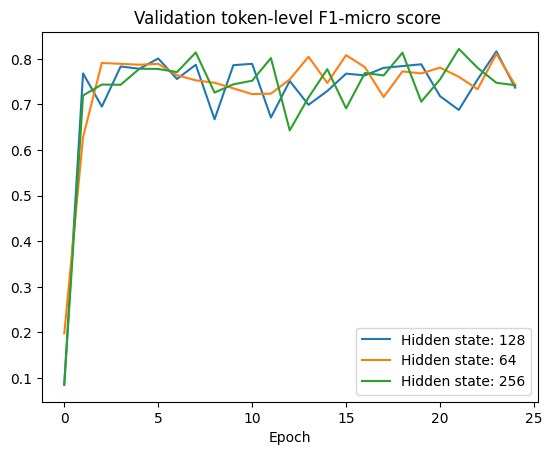

In [51]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Sample data
x = range(0, len(f1_values128))

# Plotting the lines
plt.plot(x, f1_values128, label='Hidden state: 128')
plt.plot(x, f1_values64, label='Hidden state: 64')
plt.plot(x, f1_values256, label='Hidden state: 256')

# Adding a legend
plt.legend()

# Adding labels and title
plt.xlabel('Epoch')
plt.title('Validation token-level F1-micro score ')